In [1]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 33.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=a37ba3c9e9c156986d7521ffe25ce5e970bc8e3462438274bf9d002fe46a5097
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [2]:
import numpy as np
import pandas as pd
import random
import time
import os
import json
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import matplotlib.pyplot as plt
#from langdetect import detect

#Extracting Text from json

In [ ]:
%%time
!unzip "/content/drive/MyDrive/DataSets/pdf_json.zip" -d "/content/pdf_json"

In [ ]:
def extract_text(filename):
    '''
    Extract the text from the file name (json file) and
    index the content from paper_id, title, abstract and body_text fields
    Retuns - text of title, abstract and bodt_text
    '''

    file = open(filename)
    body_text = ""
    abstract = ""
    title = ""
    paper_id = ""

    paper_content = json.load(file)

    #get the paper_id
    if 'paper_id' in paper_content:
        paper_id = paper_content['paper_id']
        
    #get the title, if available
    if 'title' in paper_content['metadata']:
        title = paper_content['metadata']['title']
    #get abstract.text, if available
    if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract = abstract + abs['text']
    if 'body_text' in paper_content:
        for bt in paper_content['body_text']:
            body_text = body_text + bt['text']


   
    return (title + ' ' + abstract + ' ' + body_text + ' ').lower()


In [ ]:
N = len(os.listdir("/content/pdf_json/pdf_json"))
print("total number of documents is : ", N)

total number of documents is :  56529


In [ ]:
file_list = os.listdir("/content/pdf_json/pdf_json")

In [ ]:
#Reading json files in different batches it will save the data into my drive
def read_json_files(start, size):
    corpus = str()
    if (start+size)>N:
        end = N
    else:
        end=(start + size)
    for file in file_list[start:end]:
        if file.endswith(".json"):
            text=extract_text(os.path.join("/content/pdf_json/pdf_json", file))
            text=text.replace("\n"," ")
            try:
                lang = detect(text)
            except:
                lang = 'other'
            if lang == 'en':
                corpus += ('\n' + text)
    with open('/content/drive/MyDrive/DataSets/pdf_json2/corpus.txt', 'a') as f:
        f.write(corpus)
    print('done upto ', end)
    return

In [ ]:
print('start at ' , 0)
for i in range(0, N, 2000):
    start = i
    read_json_files(start, 2000)

start at  0
done upto  2000
done upto  4000
done upto  6000
done upto  8000
done upto  10000
done upto  12000
done upto  14000
done upto  16000
done upto  18000
done upto  20000
done upto  22000
done upto  24000
done upto  26000
done upto  28000
done upto  30000
done upto  32000
done upto  34000
done upto  36000
done upto  38000
done upto  40000
done upto  42000
done upto  44000
done upto  46000
done upto  48000
done upto  50000
done upto  52000
done upto  54000
done upto  56000
done upto  56529


#Reading Extracted text

Reading the saved extracted text. this will read as a list. Each element of the list is a extracted text of each json.

In [ ]:
#corpus = '\n'.join(corpus_list)
corpus_file = open("/content/drive/MyDrive/DataSets/pdf_json2/corpus.txt", 'r')
corpus_list = corpus_file.readlines()
corpus_list = corpus_list[1:]
corpus_file.close()

In [ ]:
print(f'total number of english documents are {len(corpus_list)}')

total number of english documents are 54849


This function will divide the corpus in k batches. So that we work with the data separately. 

In [ ]:
def batch_divide(cor_list, k):
    '''
    Divide the whole copus into k batches so that Computattion will be easier.
    '''
    n = len(cor_list)
    m = int(n/k)
    batch_number = 1
    start = 0
    for i in range(k):
        if i ==k-1:
            subcor = '\n'.join(cor_list[start:])
        else:
            subcor = '\n'.join(cor_list[start:start+m])
            start += m
        batch_name = 'batch_' + str(batch_number)
        path = '/content/drive/MyDrive/DataSets/pdf_json2/'+batch_name+'.txt'
        with open(path, 'w') as f:
            f.write(subcor)
        print(f'creating {batch_name} done.')
        batch_number +=1
    return

In [ ]:
batch_divide(corpus_list, 9)

creating batch_1 done.
creating batch_2 done.
creating batch_3 done.
creating batch_4 done.
creating batch_5 done.
creating batch_6 done.
creating batch_7 done.
creating batch_8 done.
creating batch_9 done.


#Preprocessing

In [ ]:
def remove_links(text):
    '''
    This will remove all links with https or http
    '''
    clean_text = re.sub('https?\S+', ' ', text)
    return clean_text

def remove_citation(text):
    """
    This will remove the citations from the string. eg.- [2] or (2,3)
    """
    clean_text = re.sub('(\(|\[)[0-9, ]+(\]|\))', ' ', text)
    return clean_text

def remove_reference_to_table(text):
    '''
    To remove any kind of reference this will check if there are any 
    number in bracket if any that will be removed. e.g.- (see chart 3)
    '''
    clean_text = re.sub('(?i)(\(|\[)[a-z ]+[0-9]+[a-z]?(\]|\))', ' ', text)
    return clean_text

def remove_mail_links(text):
    '''
    To remove mail ids.
    eg. arnabsen@gmail.com, or arnabsen@cmi.ac.in
    '''
    clean_text = re.sub('[a-zA-z0-9\.\_]+[@]+\S+', ' ', text)
    return clean_text

def remove_single_word_variable(text):
    '''
    To remove any kind of single words or variables
    '''
    clean_text = re.sub('\s.\s', ' ', text)
    return clean_text

def remove_nextline(text):
    '''
    to remove \n nextline command
    '''
    clean_text = re.sub('\n', ' ', text)
    return clean_text

def remove_multiple_blank_spaces(text):
    '''
    to remove any multiple blank spaces to a single space
    '''
    clean_text = re.sub(' +', ' ', text)
    return clean_text

def remove_punctuations(text):
    '''
    To remove punctuations
    '''
    clean_text = re.sub(r'''[\[\]\(\)\{\}[`~!#$%^&*_.!?'",:;><=*\\\/\+\-\@]''', ' ', text)
    return clean_text

def remove_digits(text):
    '''
    To remove any unnecessary digits
    '''
    clean_text = re.sub(r'[+-]?\d+(?:\.\d+)?', ' ', text)
    return clean_text

def remove_non_ASCII(text):
    '''
    This regex will remove non ASCII characters like degree sign, greek alphabets.
    '''
    clean_text = re.sub(r'[^\x00-\x7F]+',' ', text)
    return clean_text

def remove_contraction(text):
    '''
    This will remove the contractions in a text like: I'm to I am, isn't to is not. 
    '''
    groups = {"'m": " am", "n't":" not", "'s": " is", "'d":" would", "'ll": " will", "'re":" are","let's":"let us"}
    for key in groups.keys():
        text = text.replace(key, groups[key])
    return text

In [ ]:
s = 'akj;fk∝jfjk[°c]'
remove_non_ASCII(s)

'akj;fk jfjk[ c]'

In [ ]:
import time
def preprocessing(batch_number):
    '''
    All regex pattern match and replace will be here.
    '''
    start_time = time.time()
    input_path = '/content/drive/MyDrive/DataSets/pdf_json2/batch_' + str(batch_number)+'.txt'
    output_path = '/content/drive/MyDrive/DataSets/pdf_json2/clean_batch_' + str(batch_number)+'.txt'
    with open(input_path, 'r') as f:
        corpus = f.read()
    cleancorpus = remove_links(corpus)
    cleancorpus = remove_contraction(cleancorpus)
    cleancorpus = remove_citation(cleancorpus)
    cleancorpus = remove_non_ASCII(cleancorpus)
    cleancorpus = remove_mail_links(cleancorpus)
    cleancorpus = remove_reference_to_table(cleancorpus)
    cleancorpus = remove_punctuations(cleancorpus)
    
    cleancorpus = remove_digits(cleancorpus)
    cleancorpus = remove_single_word_variable(cleancorpus)
    
    #cleancorpus = remove_nextline(cleancorpus)
    cleancorpus = remove_multiple_blank_spaces(cleancorpus)
    with open(output_path, 'w') as f:
        f.write(cleancorpus)
    print('preprocessing done in batch number: ', batch_number)
    end_time = time.time()
    print(f"time taken: {round((end_time - start_time),2)} seconds")
    return
for i in range(1,10):
    preprocessing(i)

preprocessing done in batch number:  1
time taken: 55.19 seconds
preprocessing done in batch number:  2
time taken: 50.08 seconds
preprocessing done in batch number:  3
time taken: 50.68 seconds
preprocessing done in batch number:  4
time taken: 51.39 seconds
preprocessing done in batch number:  5
time taken: 51.57 seconds
preprocessing done in batch number:  6
time taken: 53.58 seconds
preprocessing done in batch number:  7
time taken: 52.55 seconds
preprocessing done in batch number:  8
time taken: 50.84 seconds
preprocessing done in batch number:  9
time taken: 50.69 seconds


#delete stopwords

using spacy Stopwords it has 326 many stop words

In [ ]:
stopwords = set(STOP_WORDS)
print('length of the stop words set is : ', len(stopwords))
print(f'stopwords are : {stopwords}')

length of the stop words set is :  326
stopwords are : {'because', "'re", 'every', 'any', 'used', 'sometime', 'less', 'over', 'another', 'moreover', 'whereas', 're', 'against', 'sometimes', 'again', 'four', 'to', '’ll', 'almost', 'towards', 'just', 'hereafter', 'together', 'never', '‘m', 'nobody', 'its', 'hereby', 'a', 'get', 'third', 'least', 'among', "'s", 'ourselves', 'each', 'meanwhile', '’re', 'beforehand', 'about', 'yours', 'also', 'whoever', 'indeed', "'d", 'keep', 'very', 'noone', 'myself', 'take', 'still', 'nor', 'whole', 'above', 'whereby', 'unless', 'themselves', 'i', 'enough', 'eight', '’m', 'thereafter', 'move', 'using', 'herein', 'might', 'everything', 'with', 'himself', '’d', 'how', 'per', 'show', 'your', 'where', 'yourselves', '‘re', 'further', 'one', 'everywhere', 'few', 'them', 'this', 'as', 'anything', 'due', 'through', 'much', 'some', 'below', 'down', '’ve', 'whither', 'up', 'even', 'fifteen', 'seems', 'both', 'twenty', 'her', 'into', 'seeming', 'well', 'say', 'duri

In [ ]:
def delete_stopwords(batch_number):
    '''
    This function will read from my drive and remove the stopwords 
    and then it will save the corpus to my drive.
    '''
    start_time = time.time()
    input_path = '/content/drive/MyDrive/DataSets/pdf_json2/clean_batch_' + str(batch_number)+'.txt'
    output_path = '/content/drive/MyDrive/DataSets/pdf_json2/clean_batch_ws_' + str(batch_number)+'.txt'
    with open(input_path, 'r') as f:
        corpus = f.read()
    corpus = corpus.split(' ')
    corpus_ws = [word for word in corpus if not word in stopwords]
    corpus = ' '.join(corpus_ws)
    with open(output_path, 'w') as f:
        f.write(corpus)
    print('stop word removing done in batch number : ', batch_number)
    end_time = time.time()
    print("time taken: ", round((end_time - start_time),2), 'Seconds')
    return

for i in range(1,10):
    delete_stopwords(i)

stop word removing done in batch number :  1
time taken:  6.79 Seconds
stop word removing done in batch number :  2
time taken:  7.47 Seconds
stop word removing done in batch number :  3
time taken:  6.52 Seconds
stop word removing done in batch number :  4
time taken:  6.99 Seconds
stop word removing done in batch number :  5
time taken:  7.49 Seconds
stop word removing done in batch number :  6
time taken:  6.67 Seconds
stop word removing done in batch number :  7
time taken:  7.53 Seconds
stop word removing done in batch number :  8
time taken:  6.82 Seconds
stop word removing done in batch number :  9
time taken:  7.59 Seconds


#lemmatization

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
import time
from textblob import TextBlob, Word
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

def lemmatization_batch(batch_number):
    start_time = time.time()
    input_path = '/content/drive/MyDrive/DataSets/pdf_json2/clean_batch_ws_' + str(batch_number)+'.txt'
    output_path = '/content/drive/MyDrive/DataSets/pdf_json2/lemmatized_batch_' + str(batch_number) +'.txt'
    with open(input_path, 'r') as f:
        batch = f.read()
    processed = []
    batch = batch.split('\n')
    for sentence in batch:
        processed.append(lemmatize_with_postag(sentence))
    text="\n".join(processed)
    
    cleancorpus = remove_digits(text)
    cleancorpus = remove_single_word_variable(cleancorpus)
    
    #cleancorpus = remove_nextline(cleancorpus)
    cleancorpus = remove_multiple_blank_spaces(cleancorpus)
    with open(output_path, 'w') as f:
        f.write(cleancorpus)
    end_time = time.time()
    print('lemmatization done in batch number: ', batch_number)
    print("time taken ", (end_time - start_time), 'seconds')
    return 



In [ ]:
for i in range(1,3):
    lemmatization_batch(i)

lemmatization done in batch number:  1
time taken  1156.4271309375763 seconds
lemmatization done in batch number:  2
time taken  1136.4470965862274 seconds


In [ ]:
lemmatization_batch(3)
lemmatization_batch(4)

lemmatization done in batch number:  3
time taken  1158.8046135902405 seconds
lemmatization done in batch number:  4
time taken  1132.6581749916077 seconds


In [ ]:
lemmatization_batch(5)

lemmatization done in batch number:  5
time taken  1157.9490559101105 seconds


In [ ]:
lemmatization_batch(6)

lemmatization done in batch number:  6
time taken  1199.4704630374908 seconds


In [ ]:
lemmatization_batch(7)

lemmatization done in batch number:  7
time taken  1211.6434762477875 seconds


In [ ]:
lemmatization_batch(8)

lemmatization done in batch number:  8
time taken  1164.1853919029236 seconds


In [ ]:
lemmatization_batch(9)

lemmatization done in batch number:  9
time taken  1141.936476945877 seconds


#Calculating frequency of the words

In [ ]:
freq_dict = dict()

In [ ]:
from nltk.tokenize import word_tokenize
import time
def frequency_calc(n):
    word_count = list()
    vocab_count = list()
    count = 0
    for i in range(1,n+1):
        start_time = time.time()
        corpus_path = '/content/drive/MyDrive/DataSets/pdf_json2/lemmatized_batch_' + str(i) +'.txt'
        with open(corpus_path, 'r') as f:
            corpus = f.readlines()
        for doc in corpus:
            text_tokens = doc.split(' ')
            for word in text_tokens:
                if word != '\n':
                    count += 1
                    if str(word) in freq_dict.keys():
                        freq_dict[str(word)] += 1
                    else:
                        freq_dict[str(word)] = 1
                    if count % 10000 == 0:
                        word_count.append(count)
                        vocab_count.append(len(freq_dict.keys()))
        end_time = time.time()
        print(f'total time taken for batch {i} is {end_time-start_time} seconds')
    word_count.append(count)
    vocab_count.append(len(freq_dict.keys()))
    
    return freq_dict, word_count, vocab_count

In [ ]:
freq_dict, word_count, vocab_count = frequency_calc(9)

total time taken for batch 1 is 12.105144739151001 seconds
total time taken for batch 2 is 11.813694715499878 seconds
total time taken for batch 3 is 12.04419231414795 seconds
total time taken for batch 4 is 11.685883283615112 seconds
total time taken for batch 5 is 11.777775049209595 seconds
total time taken for batch 6 is 12.017798900604248 seconds
total time taken for batch 7 is 12.189282417297363 seconds
total time taken for batch 8 is 12.387763738632202 seconds
total time taken for batch 9 is 12.203110933303833 seconds


In [ ]:
sorted_freq = {k: v for k, v in sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
rank = 1
words = list()
for key in sorted_freq.keys():
    temp = [rank, key, sorted_freq[key], rank*sorted_freq[key]]
    rank += 1
    words.append(temp)
df = pd.DataFrame(words)

In [ ]:
df.rename(columns = {0:'rank', 1:'word', 2: 'frequency', 3:'rank*freq'}, inplace = True)
#df = df.drop('Unnamed: 0', 1)
df.set_index('rank')

,word,frequency,rank*freq
rank,,,
1,patient,900582,900582
2,cell,813280,1626560
3,study,705481,2116443
4,al,580996,2323984
5,et,580000,2900000
...,...,...,...
762681,xcep,1,762681
762682,tionnet,1,762682
762683,cormobilities,1,762683


In [ ]:
df.head(3)

,rank,word,frequency,rank*freq
0,1,patient,900582,900582
1,2,cell,813280,1626560
2,3,study,705481,2116443


In [ ]:
df.to_csv('/content/drive/MyDrive/DataSets/pdf_json2/frequency_dataframe.csv')

# From frequency DataFrame

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DataSets/pdf_json2/frequency_dataframe.csv')

In [ ]:
df.head(3)

,Unnamed: 0,rank,word,frequency,rank*freq
0,0,1,patient,900582,900582
1,1,2,cell,813280,1626560
2,2,3,study,705481,2116443


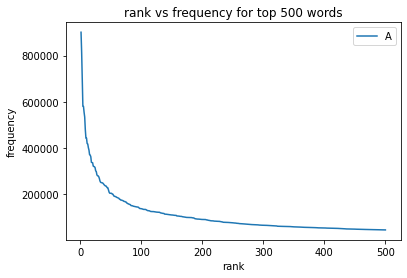

In [ ]:
plt.plot(df['rank'][:500], (df['frequency'][:500]))
plt.xlabel('rank')
plt.ylabel('frequency')
plt.legend('Actual')
plt.title('rank vs frequency for top 500 words')
plt.show()

frequency $∝ \frac{1}{r^ᵅ} \n \implies frequency = \frac{k}{r^\alpha} \implies α  = \frac{\log k - \log frequency}{\log r}$


In [ ]:
k = df['frequency'][0]

In [ ]:
def alpha_estimates(rank, freq):
    return (np.log(k/freq))/np.log(rank)

def alpha_df(df):
    alphas = list()
    for i in range(len(df)):
        ta = alpha_estimates(df['rank'][i], df['frequency'][i])
        alphas.append(ta)
    return alphas[1:]

In [ ]:
a = alpha_df(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
alpha = np.mean(a)
print(f'Value of alpha is {alpha}')

Value of alpha is 1.003945605447623


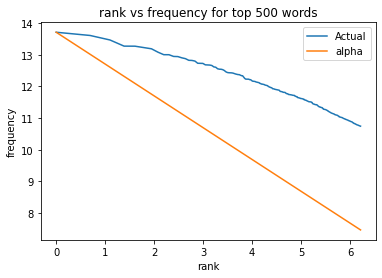

In [ ]:
x = df['rank'][:500]
y1 = df['frequency'][:500]
y2 = k/(x**alpha)
plt.plot(np.log(x), np.log(y1))
plt.plot(np.log(x),np.log(y2))
plt.xlabel('rank')
plt.ylabel('frequency')
plt.legend(['Actual','alpha'])
plt.title('rank vs frequency for top 500 words')
plt.show()

In [ ]:
df.tail()

,Unnamed: 0,rank,word,frequency,rank*freq
762680,762680,762681,xcep,1,762681
762681,762681,762682,tionnet,1,762682
762682,762682,762683,cormobilities,1,762683
762683,762683,762684,progation,1,762684
762684,762684,762685,preprintdecision,1,762685


#Heaps Law

In [ ]:
vocab_dict = dict()
vocab_dict['word count'] = word_count
vocab_dict['vocabulary count'] = vocab_count
vocab_df = pd.DataFrame(vocab_dict)
vocab_df.to_csv('/content/drive/MyDrive/DataSets/pdf_json2/vocab_datframe.csv', index = False)

In [ ]:
vocab_df = pd.read_csv('/content/drive/MyDrive/DataSets/pdf_json2/vocab_datframe.csv')
w = vocab_df['word count']
v = vocab_df['vocabulary count']
log_w = np.log(w)
log_v = np.log(v)


In [ ]:
x1 = log_w[0]
x2 = log_v[1000]
y1 = log_w[0]
y2 = log_v[1000]

b = (y2-y1)/(x2-x1)
log_k = y1 - (b*x1)

log_M_estimate=log_k + (b*log_w)

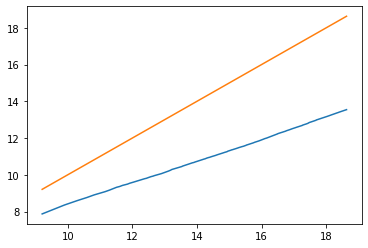

In [ ]:
plt.plot(np.log(w), np.log(v))
plt.plot(np.log(w), log_M_estimate)
plt.show()